#  <font color='#57998f'>Computing Equilibria | FP & RL</font>
###  <font color='#37665f'>Dependencies</font> 

In [300]:
import pandas as pd
import numpy as np
import pulp

###  <font color='#37665f'>Games</font> 

In [236]:
# Game: matching pennies
payoff_matrix = np.array([[ 1,-1],
                          [-1, 1]])

# Game: rock-paper-scissors
# payoff_matrix = np.array([[ 0,-1, 1],
#                           [ 1, 0,-1],
#                           [-1, 1, 0]])

# Game: zero-sum with pure nash equilibrium
# payoff_matrix = np.array([[ 2, 0, 1],
#                           [-4,-3, 2],
#                           [ 1,-2,-2]])

###  <font color='#37665f'>Fictitious Play</font> 
####  <font color='#425451'>Define Player</font> 

In [245]:
class FPZeroSumPlayer():

    def __init__(self, payoff_matrix):
        
        self.payoff_matrix = payoff_matrix
        
        self.w = np.random.uniform(low=0.5, high=1.0, size=(len(self.payoff_matrix),))
        self.p = self.w / np.sum(self.w)
        
        self.action = None
        self.reward_history = []


    def take_action(self, learning=True):
        
        belief = np.argmax(self.p)
        
        self.action = np.argmax(self.payoff_matrix[:,belief])

        return self.action

    
    def learn(self,opponent_action):
        
        self.w[opponent_action] += 1
        
        self.p = self.w / np.sum(self.w)
        
        reward = payoff_matrix[self.action][opponent_action]
        self.reward_history.append(reward)

####  <font color='#425451'>Initialize Players</font> 

In [246]:
player_1 = FPZeroSumPlayer(payoff_matrix)

column_payoff_matrix = (-1) * payoff_matrix.T
player_2 = FPZeroSumPlayer(column_payoff_matrix)

####  <font color='#425451'>Play Game</font> 

In [277]:
for i in range(1000):
    
    action_1 = player_1.take_action()
    action_2 = player_2.take_action()

    player_1.learn(opponent_action=action_2)
    player_2.learn(opponent_action=action_1)    

In [278]:
player_1.p.round(3)

array([0.496, 0.504])

In [279]:
player_2.p.round(3)

array([0.506, 0.494])

###  <font color='#37665f'>Reinforcement Learning</font> 
####  <font color='#425451'>Reward helper function</font> 

In [293]:
def get_reward(payoff_matrix, action_1, action_2):
    
    reward_1 = payoff_matrix[action_1, action_2]
    reward_2 = (-1) * payoff_matrix[action_1, action_2]

    return reward_1, reward_2

####  <font color='#425451'>Define Player</font> 

In [296]:
class RLZeroSumPlayer():

    def __init__(self, alpha, gamma, explor, actions, state_init='s'):

        self.alpha = alpha
        self.gamma = gamma
        self.explor = explor
        self.actions = actions
        self.state = state_init
        
        self.states = []
        
        self.Q = {}
        self.V = {}
        self.Pi = {}
        self.action = None

        self.init_state(state_init)

        self.game_history = []
        
    def init_state(self, state):
        
        self.states.append(state)
        
        self.V[state] = 1

        for action_1 in self.actions: 
            for action_2 in self.actions:
                self.Q[(state, action_1, action_2)] = 1

        for action in self.actions:
            self.Pi[(state, action)] = 1/len(self.actions) 


    def take_action(self, learning=True):

        if learning & (np.random.rand() < self.explor): 
            self.action = np.random.choice(self.actions)
        else:
            self.action = np.random.choice([i[1] for i in self.Pi.keys() if i[0]==self.state], 
                                           p=[self.Pi[i] for i in self.Pi.keys() if i[0]==self.state])   

        return self.action

    
    def learn(self, reward, opponent_action, state='s'):
        
        if state not in self.states: 
            self.init_state(state)
        
        self.update_Q(reward, opponent_action, state)
        self.update_Pi()
        self.update_V(state)
        
        self.game_history.append((self.state, self.action, opponent_action))
        
        self.state = state

    def update_Q(self, reward, opponent_action, new_state):
        
        kappa = len([i for i in player_1.game_history if i == (self.state, self.action, opponent_action)])
        alpha = 1/kappa if kappa>0 else self.alpha
        
        current_Q = self.Q[(self.state, self.action, opponent_action)]
        updated_Q = (1 - alpha)*current_Q + alpha*(reward + self.gamma*self.V[new_state])
        
        self.Q[(self.state, self.action, opponent_action)] = updated_Q

        
    def update_Pi(self):     
        
        pi = pulp.LpVariable.dicts('pi', self.actions, 0, 1)
        maxmin = pulp.LpVariable('maxmin')
        lp_prob = pulp.LpProblem('MaxMinQ', pulp.LpMaximize)
        lp_prob += (maxmin, 'Objective')
        lp_prob += (sum([pi[i] for i in self.actions]) == 1)

        for opponent_action in self.actions:
            label = '{}'.format(opponent_action)
            l = [pi[idx] * self.Q[(self.state, action, opponent_action)] for idx, action in enumerate(self.actions)]
            values = pulp.lpSum(l)
            condition = maxmin <= values
            lp_prob += condition

        lp_prob.solve(pulp.PULP_CBC_CMD(msg=0))

        for i in self.actions:
            self.Pi[(self.state,i)] = pi[i].value()
        
    def update_V(self, state):
        
        expected_values = []

        for opponent_action in self.actions:
            expected_value = sum([self.Pi[(state, action)]*self.Q[(state, action, opponent_action)] for action in self.actions])
            expected_values.append(expected_value)

        self.V[self.state] = min(expected_values)


####  <font color='#425451'>Initialize Players</font> 

In [301]:
alpha = 1
gamma = 0.9
explor = 0.2initial_state = 's'
actions = list(range(len(payoff_matrix)))

player_1 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)
player_2 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)

####  <font color='#425451'>Play Game</font> 

In [302]:
for i in range(30):
    action_1 = player_1.take_action()
    action_2 = player_2.take_action()
    reward_1, reward_2 = get_reward(payoff_matrix, action_1, action_2)

    player_1.learn(reward=reward_1, opponent_action=action_2, state='s')
    player_2.learn(reward=reward_2, opponent_action=action_1, state='s')

In [303]:
player_1.Pi

{('s', 0): 1.0, ('s', 1): 0.0, ('s', 2): 0.0}

In [304]:
player_2.Pi

{('s', 0): 0.0, ('s', 1): 1.0, ('s', 2): 0.0}

In [965]:
player_1.Q

{('s', 0, 0): 0.511739041418778,
 ('s', 0, 1): -0.46894533421389384,
 ('s', 0, 2): 1.5255158416624242,
 ('s', 1, 0): 1.4718432159306762,
 ('s', 1, 1): 0.5246538664620221,
 ('s', 1, 2): -0.48618140391765063,
 ('s', 2, 0): -0.46158769243854736,
 ('s', 2, 1): 1.4887251791263676,
 ('s', 2, 2): 0.5516505936055593}

In [820]:
player_2.Q

{('s', 0, 0): -3.1145124990541406,
 ('s', 0, 1): -4.460190067974099,
 ('s', 0, 2): -1.2287022756591568,
 ('s', 1, 0): -1.9921616904121933,
 ('s', 1, 1): -0.9057646991740385,
 ('s', 1, 2): -5.084471600172694,
 ('s', 2, 0): -3.1031289466270326,
 ('s', 2, 1): -3.710574216520802,
 ('s', 2, 2): 0.16267220541912877}

In [806]:
payoff_matrix

[[(2, -2), (0, 0), (1, -1)],
 [(4, -4), (-1, 1), (2, -2)],
 [(1, -1), (3, -3), (-2, 2)]]

####  <font color='#425451'>Drafts</font> 

In [378]:
pi = pulp.LpVariable.dicts('pi', player_1.actions, 0, 1)
maxmin = pulp.LpVariable('maxmin')
lp_prob = pulp.LpProblem('MaxMinQ', pulp.LpMaximize)
lp_prob += (maxmin, 'Objective')
lp_prob += (sum([pi[i] for i in player_1.actions]) == 1)

for opponent_action in player_1.actions:
    label = '{}'.format(opponent_action)
    l = [pi[idx] * player_1.Q[(player_1.state, action, opponent_action)] for idx, action in enumerate(player_1.actions)]
    values = pulp.lpSum(l)
    condition = maxmin <= values
    lp_prob += condition
    
lp_prob.solve(pulp.PULP_CBC_CMD(msg=0))

for i in player_1.actions:
    player_1.Pi[(player_1.state,i)] = pi[i].value()

[0.0, 0.0, 1.0]

In [380]:
lp_prob

MaxMinQ:
MAXIMIZE
1*maxmin + 0
SUBJECT TO
_C1: pi_0 + pi_1 + pi_2 = 1

_C2: maxmin - pi_0 - pi_1 - pi_2 <= 0

_C3: maxmin - pi_0 - pi_1 - 1.9 pi_2 <= 0

_C4: maxmin - pi_0 - pi_1 - pi_2 <= 0

VARIABLES
maxmin free Continuous
pi_0 <= 1 Continuous
pi_1 <= 1 Continuous
pi_2 <= 1 Continuous

Text(0.5, 0, '\n Training Dataset Size')

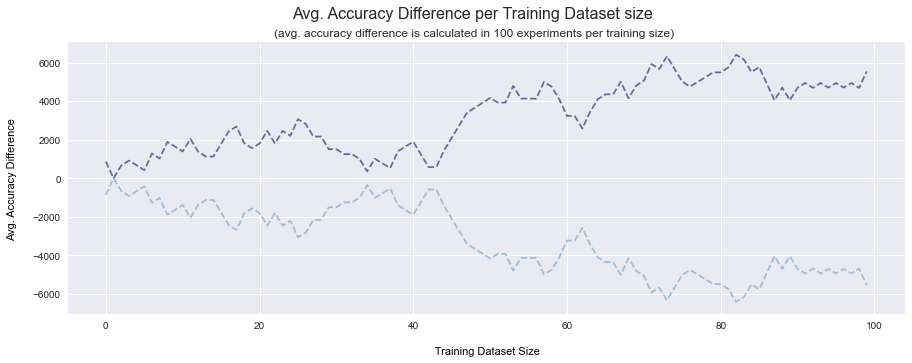

In [26]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('seaborn')
color_plt = sns.color_palette("ch:s=.25,rot=-.25")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 5)
ax = plt.gca()

plot = plt.plot([i for i in range(len(rewards_p1_cum))], rewards_p1_cum, ls ='--', color=color_plt[1], label='')
plot = plt.plot([i for i in range(len(rewards_p2_cum))], rewards_p2_cum, ls ='--', color=color_plt[3], label='')

plt.suptitle('Avg. Accuracy Difference per Training Dataset size', fontsize=16)
plt.title('(avg. accuracy difference is calculated in 100 experiments per training size)       ')
plt.yticks(fontsize=10)
plt.ylabel('Avg. Accuracy Difference\n', fontsize=11, color='black')
plt.xlabel('\n Training Dataset Size', fontsize=11, color='black')

In [305]:
# c=0
# rewards_p2_cum = np.array([])
# for i in rewards_p2:
#     print(c)
#     c += i
#     rewards_p2_cum = np.append(rewards_p2_cum, c)

In [94]:
rewards_p1_cum = np.array([])
